## Import libraries and datafram

In [1]:
# import libraries
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')


In [2]:
# import gdp data
path = r'G:\Career Foundery\CFundry-6'
gdp = pd.read_pickle(os.path.join(path , '2 Data set', 'Modified', 'euro_gdp.pkl'))
gdp.head()

,country,time-period,GDP(mm-euro)
0,Austria,1995-Q1,59780.9
1,Austria,1995-Q2,60233.1
2,Austria,1995-Q3,60432.1
3,Austria,1995-Q4,61000.1
4,Austria,1996-Q1,61194.2


In [20]:
# as we want just consider the time series analysis in this task, we have to select the 
# gdp values for one country through the time, so we select the values for germany
gdp_germ = gdp[gdp['country']=='Germany']
gdp_germ

,country,time-period,GDP(mm-euro)
804,Germany,1991-Q1,557498.0
805,Germany,1991-Q2,554547.5
806,Germany,1991-Q3,553337.0
807,Germany,1991-Q4,560448.6
808,Germany,1992-Q1,568978.5
...,...,...,...
925,Germany,2021-Q2,800046.3
926,Germany,2021-Q3,806023.1
927,Germany,2021-Q4,805644.7
928,Germany,2022-Q1,811999.7


In [21]:
# we have to change time period into a datatime format
gdp_germ['year'] = np.array(gdp_germ['time-period'].str.split('-').tolist())[:,0].tolist()
gdp_germ['quarter'] = np.array(gdp_germ['time-period'].str.split('-').tolist())[:,1].tolist()
gdp_germ.loc[gdp_germ['quarter']=='Q1', 'month'] = '01-01'
gdp_germ.loc[gdp_germ['quarter']=='Q2', 'month'] = '04-01'
gdp_germ.loc[gdp_germ['quarter']=='Q3', 'month'] = '07-01'
gdp_germ.loc[gdp_germ['quarter']=='Q4', 'month'] = '10-01'
gdp_germ['Date'] = gdp_germ['year'] + '-' + gdp_germ['month']
gdp_germ['Date'] = pd.to_datetime(gdp_germ['Date'])
gdp_germ = gdp_germ.drop(columns=['country', 'time-period','year','quarter','month'])
gdp_germ = gdp_germ.set_index('Date')
gdp_germ.head()

,GDP(mm-euro)
Date,
1991-01-01,557498.0
1991-04-01,554547.5
1991-07-01,553337.0
1991-10-01,560448.6
1992-01-01,568978.5


In [23]:
gdp_germ.shape

(126, 1)

In [25]:
gdp_germ.describe()

,GDP(mm-euro)
count,126.000000
mean,680547.661111
std,80247.211349
min,553337.000000
25%,611359.325000
50%,667868.500000
75%,743267.650000
max,813456.200000


In [28]:
gdp_germ.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 126 entries, 1991-01-01 to 2022-04-01
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   GDP(mm-euro)  126 non-null    float64
dtypes: float64(1)
memory usage: 2.0 KB


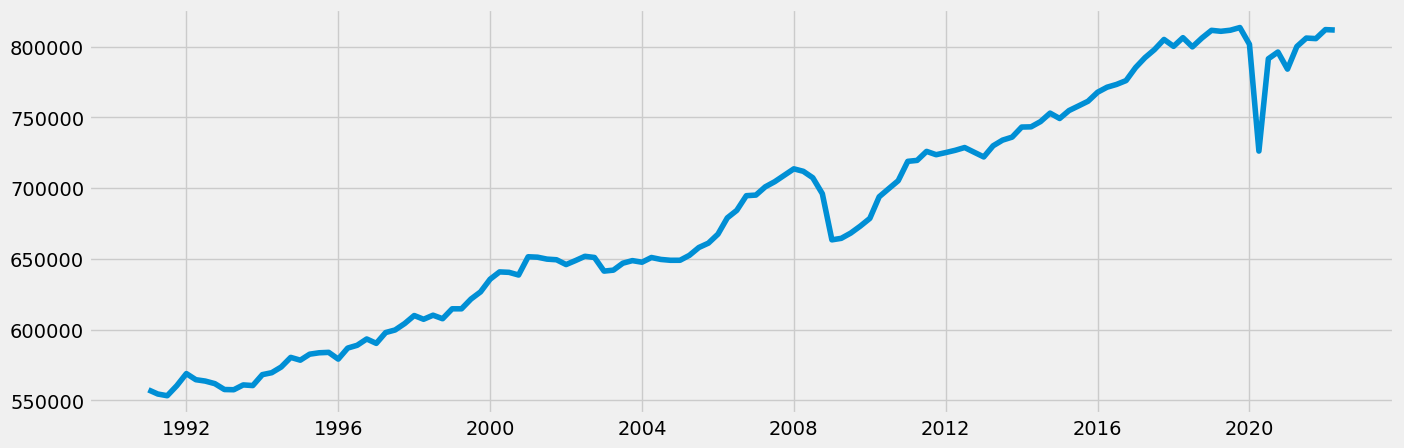

In [29]:
# plot the dataset
plt.figure(figsize=(15,5), dpi=100)
plt.plot(gdp_germ)

### The shape of this time series shows that we have a upward general trend with some cycles during economic recessions around 2009-2010 and also 2020-2021. So we expect non-stationarity behaviour from this time-series and we must in the next steps statistically confirm and treat it. 

In [31]:
gdp_germ.isnull().sum()

GDP(mm-euro)    0
dtype: int64

In [32]:
gdp_germ[gdp_germ.duplicated()]

,GDP(mm-euro)
Date,
1999-04-01,614749.7


#### There is no null value. The value of GDP for 1999-01-01 and 1999-04-01 are the same. It can be a typing error or just imputation for a missing value in the original dataset. As we don't have any reliable information about the reason of this similarity we let it remain in the time series

### The time interval in this data set seems to be acceptable as it is from 1990 till 2022. So there is no very old data and also no prediction in this time series. We'll use the same time interval for the rest of our analysis,

# Time-series Analysis: Decomposition

In [36]:
# Decompose the time series using an additive model since the trend seems to be linear

decomposition = sm.tsa.seasonal_decompose(gdp_germ, model='additive')

In [37]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

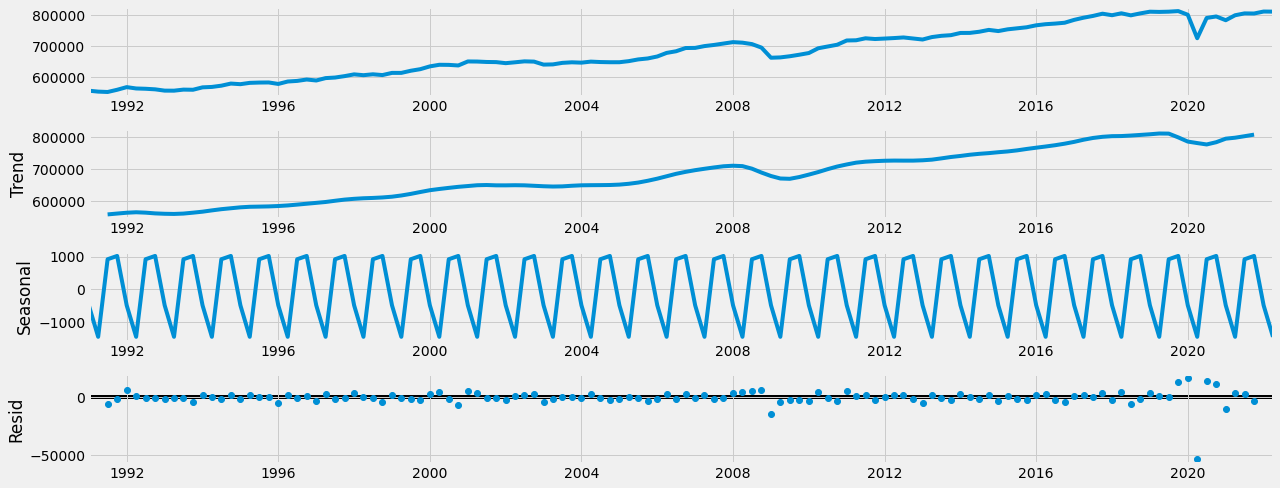

In [38]:
# Plot the separate components

decomposition.plot()
plt.show()

### After decomposition the upward trend is more obvious and also a low amount of seasonality (1000) was extracted too. The residuals are insignificant except for those time periods that we had sharp decline in gdp (2010 & 2020)

# Time-series Analysis: Test of Stationarity


In [39]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why we need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(gdp_germ['GDP(mm-euro)'])

Dickey-Fuller Stationarity test:
Test Statistic                  -0.480021
p-value                          0.895857
Number of Lags Used              2.000000
Number of Observations Used    123.000000
Critical Value (1%)             -3.484667
Critical Value (5%)             -2.885340
Critical Value (10%)            -2.579463
dtype: float64


### According to the fact that test statistics is greater than all critical values, and also the p-value is 0.8958>0.05 we cannot reject the null hypothesis and therefore the time series is not stationary. 

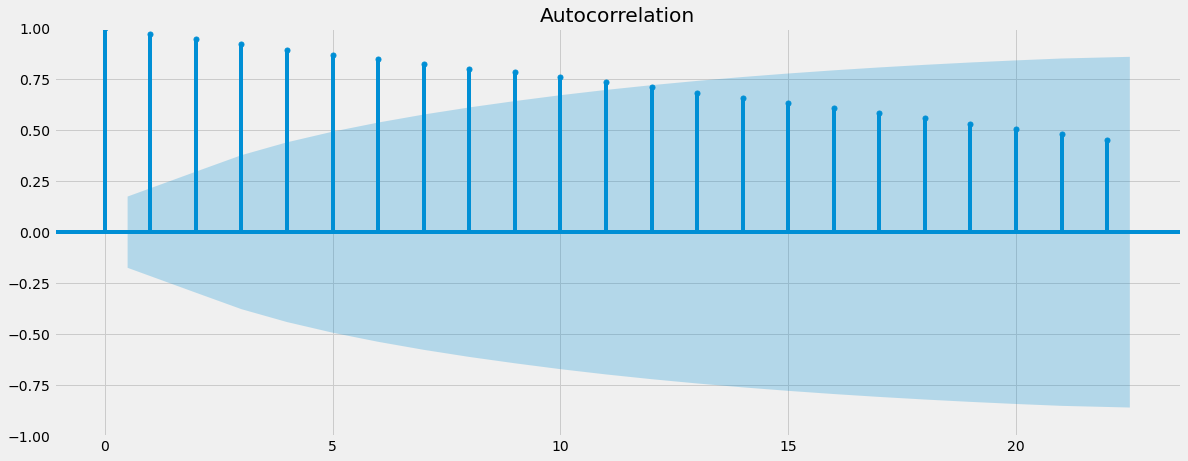

In [40]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(gdp_germ)
plt.show()

### More than 10 lags are beyound the confidence interval so this is another confirmation of non-stationarity of our time-series. 

## 5. Stationarizing the Data

In [41]:
# The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)
gdp_diff = gdp_germ - gdp_germ.shift(1)
# Here, we remove the missing values that came about as a result of the differencing. 
gdp_diff.dropna(inplace = True) 
gdp_diff.head()

,GDP(mm-euro)
Date,
1991-04-01,-2950.5
1991-07-01,-1210.5
1991-10-01,7111.6
1992-01-01,8529.9
1992-04-01,-4312.2


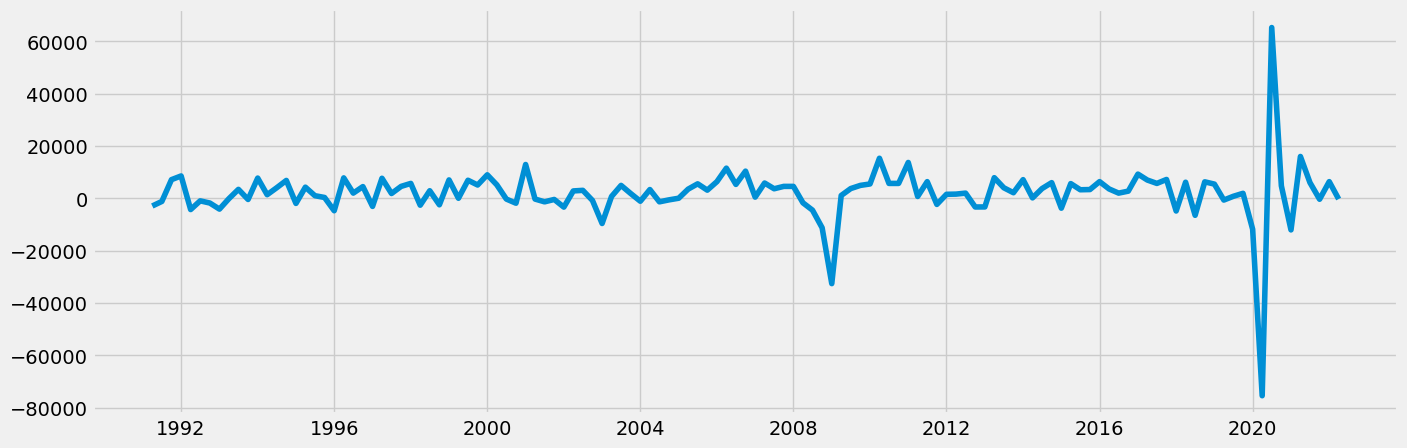

In [42]:
# plot the new differentiated time-series
plt.figure(figsize=(15,5), dpi=100)
plt.plot(gdp_diff)

### The appearance of this graph shows more stationarity behaviour for the time-series. And except two sharp fluctuation in 2010 and 2020 the other parts of the graph seems to have constatnt mean and std. However, we should check it by adfuller test and acf plots

In [43]:
dickey_fuller(gdp_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -1.001215e+01
p-value                        1.767053e-17
Number of Lags Used            1.000000e+00
Number of Observations Used    1.230000e+02
Critical Value (1%)           -3.484667e+00
Critical Value (5%)           -2.885340e+00
Critical Value (10%)          -2.579463e+00
dtype: float64


### As the test statistics (-10) is smaller than all critical values and also p-value (1.7e-17) is smaller than 0.05 we can reject the null hypothesis and therefore the time-series is stationary. For confirmation we'll plot acf in the next part.

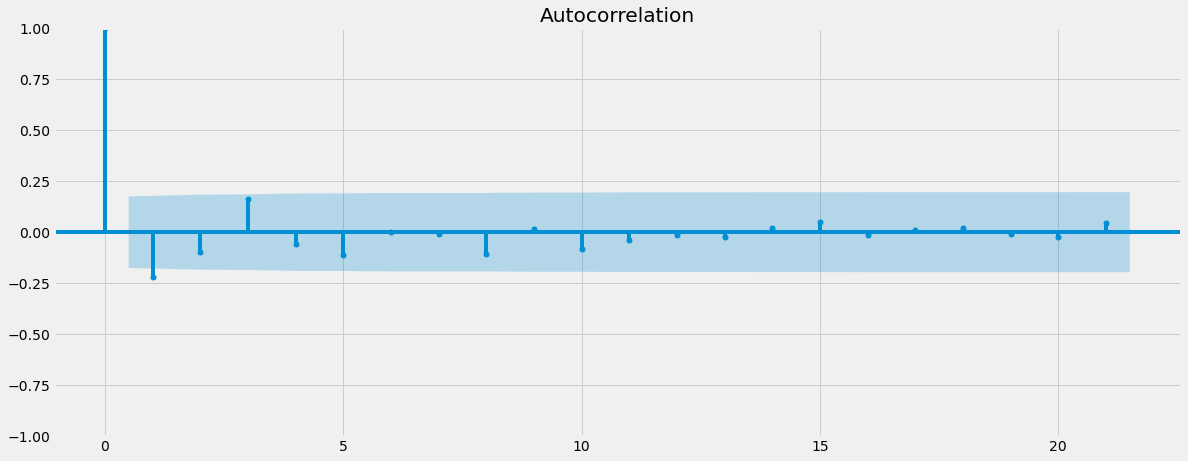

In [44]:
plot_acf(gdp_diff)
plt.show()

### The autocorrelation graph is confirm the stationarity as none of the lags are beyound the confidence interval. Therefore we can use the current form of time-series for prediction. 

# Time-series Forecasting

### Define parameters

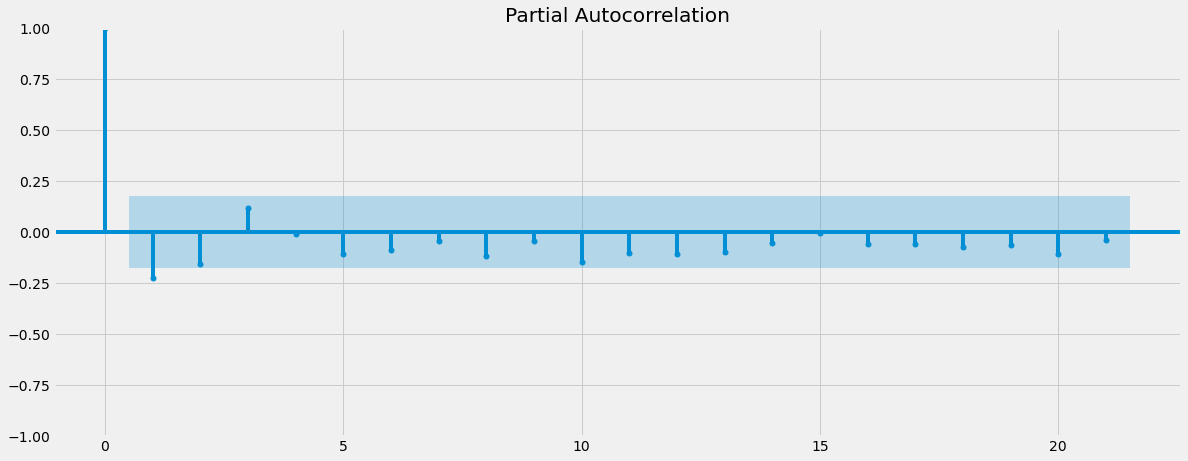

<Figure size 4500x4500 with 0 Axes>

In [45]:
# Plot partial autocorrelations to determine parameter p

plot_pacf(gdp_diff)
plt.figure(figsize=(15,15), dpi=300)
plt.show()

#### In the above diagram there is only one positive autocorrelation in lag=3, therefor for first try we consider p=3

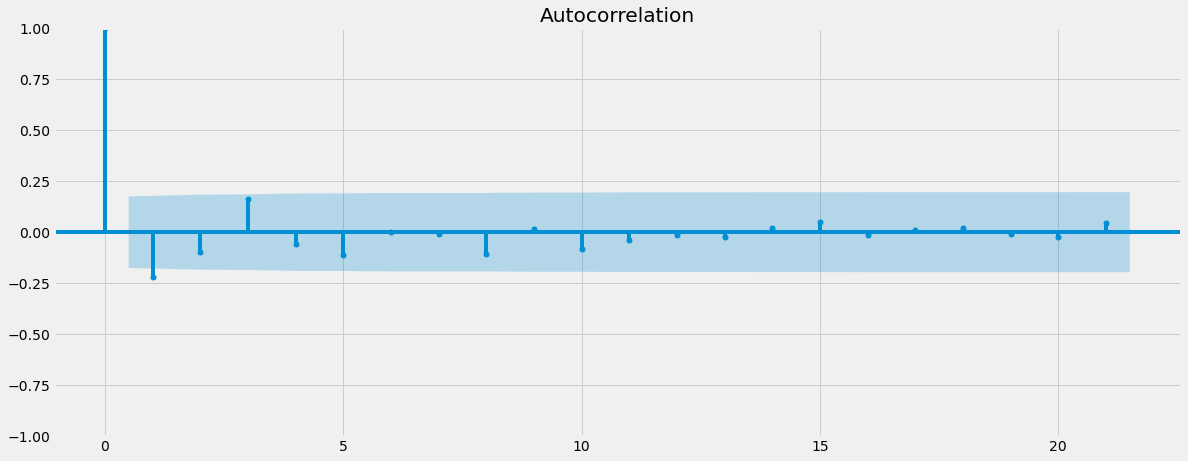

<Figure size 1500x500 with 0 Axes>

In [46]:
# Plot autocorrelations to determine parameter q

plot_acf(gdp_diff)
plt.figure(figsize=(15,5), dpi=100)
plt.show()

#### In tis plot there is only one significant autocorrelation. therefore we consider q=1.


### Splitting data

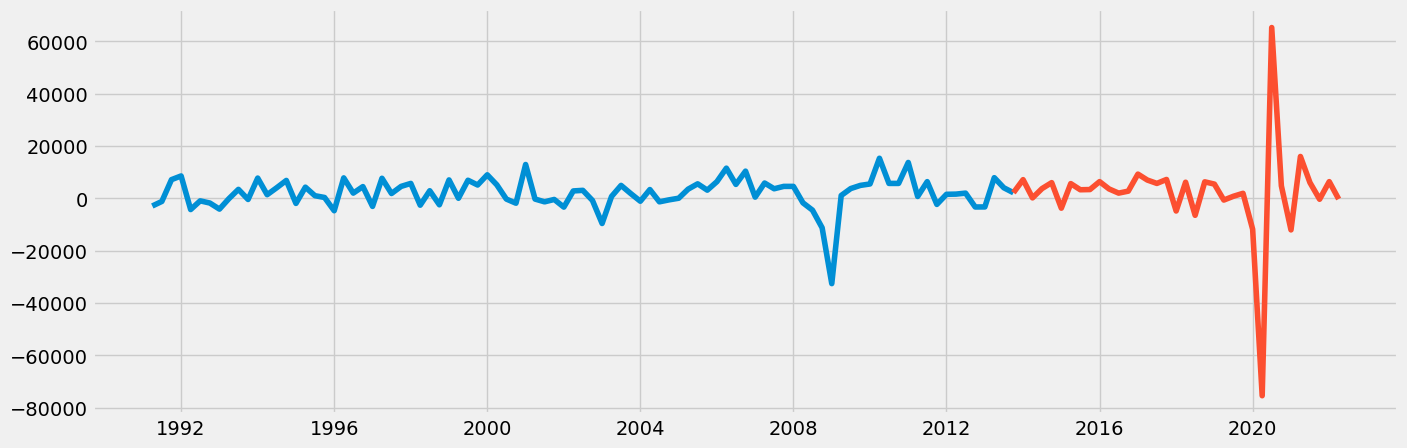

In [48]:
# Split the data

train = gdp_diff['GDP(mm-euro)'][:91]
test = gdp_diff['GDP(mm-euro)'][90:]

# Plot both sets in order to see the split

plt.figure(figsize=(15,5), dpi=100)
plt.plot(train)
plt.plot(test)

In [49]:
test.shape

(35,)

### Running and Fitting the Model

                               SARIMAX Results                                
Dep. Variable:           GDP(mm-euro)   No. Observations:                   91
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -908.582
Date:                Sat, 03 Sep 2022   AIC                           1823.163
Time:                        21:46:05   BIC                           1830.662
Sample:                    04-01-1991   HQIC                          1826.187
                         - 10-01-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2590      0.088      2.932      0.003       0.086       0.432
ma.L1         -1.0000      0.098    -10.186      0.000      -1.192      -0.808
sigma2      3.305e+07   2.97e-09   1.11e+16      0.0

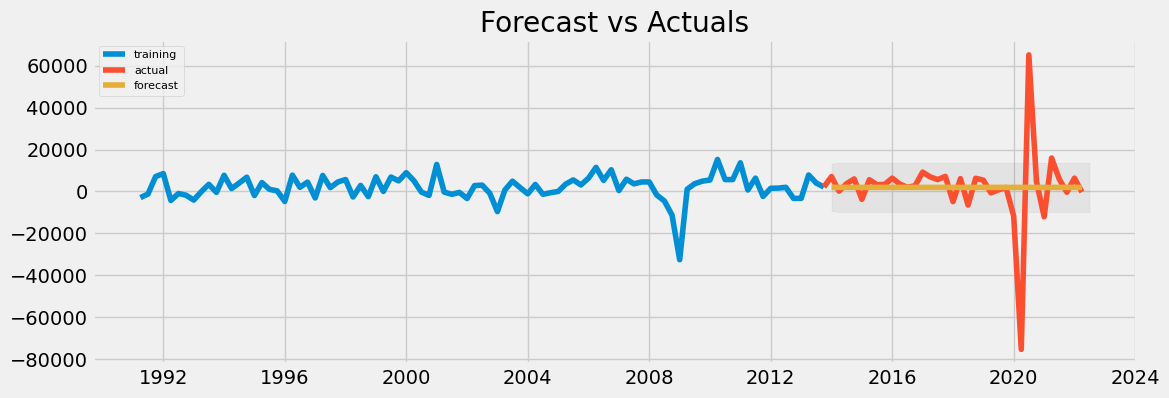

In [78]:
# Import the model we need
from statsmodels.tsa.api import ARIMA 

model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit()  
print(fitted.summary()) # Check model summary

# Forecast
# 95% confidence interval  --> alpha = 0.05; 35 is the shape of the test set
fc = fitted.forecast(35, alpha=0.05)  
forecast = fitted.get_forecast(35)
se = forecast.predicted_mean
conf = forecast.conf_int(alpha=0.05)
# Make into pandas series
fc_series = pd.Series(fc, index=test.index) # This creates the forecasted curve
lower_series = pd.Series(conf['lower GDP(mm-euro)']) # lower bound of the confidence interval
upper_series = pd.Series(conf['upper GDP(mm-euro)']) # Upper bound of the confidence interval

# Plot
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05) # This creates the confidence interval
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### By trying different parameters for p,d,q we observed only for (1,1,1) parameters the ar and ma coefficients are significant and increasing these parameters has no effect on accuracy of the forecast. Actually as this time-series is stationary with constant mean and std the forecast is a flat line equal to the mean value. Infact, if we omit the two points with abnormal high oscilations this prediction is a good match with other points. We should notice that this flucuation is a result of economic recession due to corona pandemy and it is not foecastable by this model. 